In [4]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import folium
import sys
from tqdm.notebook import tqdm

# Set plot style for better aesthetics
sns.set_theme(style="whitegrid")


In [6]:
# Define the root directory of your database
root_path = Path("../data/database")

# Check if the directory exists
if not root_path.exists():
    print(f"Error: The directory '{root_path}' does not exist.")
    print("Please make sure the path is correct.")
else:
    all_records = []
    # Define the column names based on your filename structure
    # The first element from split is empty because the string starts with '@'
    column_names = [
        "lat1", "lon1", "lat2", "lon2", "lat3", "lon3", "lat4", "lon4",
        "image_id", "timestamp", "nadir_lat", "nadir_lon", "sq_km_area",
        "orientation"
    ]

    # Use rglob to recursively find all .jpg files
    # tqdm will show a progress bar, which is useful for large datasets
    print("Scanning all image files and parsing metadata...")
    for filepath in tqdm(list(root_path.rglob("*.jpg"))):
        try:
            # Extract year and zoom from the directory structure
            dir_parts = filepath.parts
            year_zoom_str = dir_parts[-3] # e.g., '2018_09'
            year = int(year_zoom_str.split("_")[0])
            zoom = int(year_zoom_str.split("_")[1])

            # Parse the filename
            filename_parts = filepath.stem.split("@")[1:]
            
            # Create a dictionary for the current record
            record = {"year": year, "zoom": zoom, "filepath": str(filepath)}
            record.update(zip(column_names, filename_parts))
            all_records.append(record)
        except (IndexError, ValueError) as e:
            print(f"Could not parse file: {filepath}. Error: {e}")

    # Create the DataFrame
    df = pd.DataFrame(all_records)

    # --- Data Cleaning ---
    # Convert relevant columns to numeric types for calculations and plotting
    numeric_cols = [
        "lat1", "lon1", "lat2", "lon2", "lat3", "lon3", "lat4", "lon4",
        "nadir_lat", "nadir_lon", "sq_km_area", "orientation", "year", "zoom"
    ]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop rows where essential numeric conversion failed
    df.dropna(subset=numeric_cols, inplace=True)

    print(f"\nSuccessfully loaded and parsed {len(df)} images.")
    print("DataFrame Info:")
    df.info()
    print("\nFirst 5 rows of the dataset:")
    display(df.head())

Scanning all image files and parsing metadata...


  0%|          | 0/645984 [00:00<?, ?it/s]


Successfully loaded and parsed 645984 images.
DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645984 entries, 0 to 645983
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   year         645984 non-null  int64  
 1   zoom         645984 non-null  int64  
 2   filepath     645984 non-null  object 
 3   lat1         645984 non-null  float64
 4   lon1         645984 non-null  float64
 5   lat2         645984 non-null  float64
 6   lon2         645984 non-null  float64
 7   lat3         645984 non-null  float64
 8   lon3         645984 non-null  float64
 9   lat4         645984 non-null  float64
 10  lon4         645984 non-null  float64
 11  image_id     645984 non-null  object 
 12  timestamp    645984 non-null  object 
 13  nadir_lat    645984 non-null  float64
 14  nadir_lon    645984 non-null  float64
 15  sq_km_area   645984 non-null  int64  
 16  orientation  645984 non-null  int64  
dtypes: f

year  zoom                                           filepath      lat1  \
0  2020     9  ../data/database/2020_09/40_60/@34.30714@54.84...  34.30714   
1  2020     9  ../data/database/2020_09/40_60/@43.06889@63.28...  43.06889   
2  2020     9  ../data/database/2020_09/40_60/@43.06889@60.46...  43.06889   
3  2020     9  ../data/database/2020_09/40_60/@36.59789@56.25...  36.59789   
4  2020     9  ../data/database/2020_09/40_60/@39.90974@61.87...  39.90974   

       lon1      lat2      lon2      lat3      lon3      lat4      lon4  \
0  54.84375  36.59789  54.84375  36.59789  57.65625  34.30714  57.65625   
1  63.28125  45.08904  63.28125  45.08904  66.09375  43.06889  66.09375   
2  60.46875  45.08904  60.46875  45.08904  63.28125  43.06889  63.28125   
3  56.25000  38.82259  56.25000  38.82259  59.06250  36.59789  59.06250   
4  61.87500  42.03297  61.87500  42.03297  64.68750  39.90974  64.68750   

       image_id timestamp  nadir_lat  nadir_lon  sq_km_area  orientation  
0  09_0200_0334      2020   35.45252   56.25000       65031            0  
1  09_0184_0346      2020   44.07896   64.68750       50576            0  
2  09_0184_0342      2020   44.07896   61.87500       50576            0  
3  09_0196_0336      2020   37.71024   57.65625       61336            0  
4  09_0190_0344      2020   40.97136   63.28125       55869            0


Generating Plot 2: Distribution of Image Area (km²)


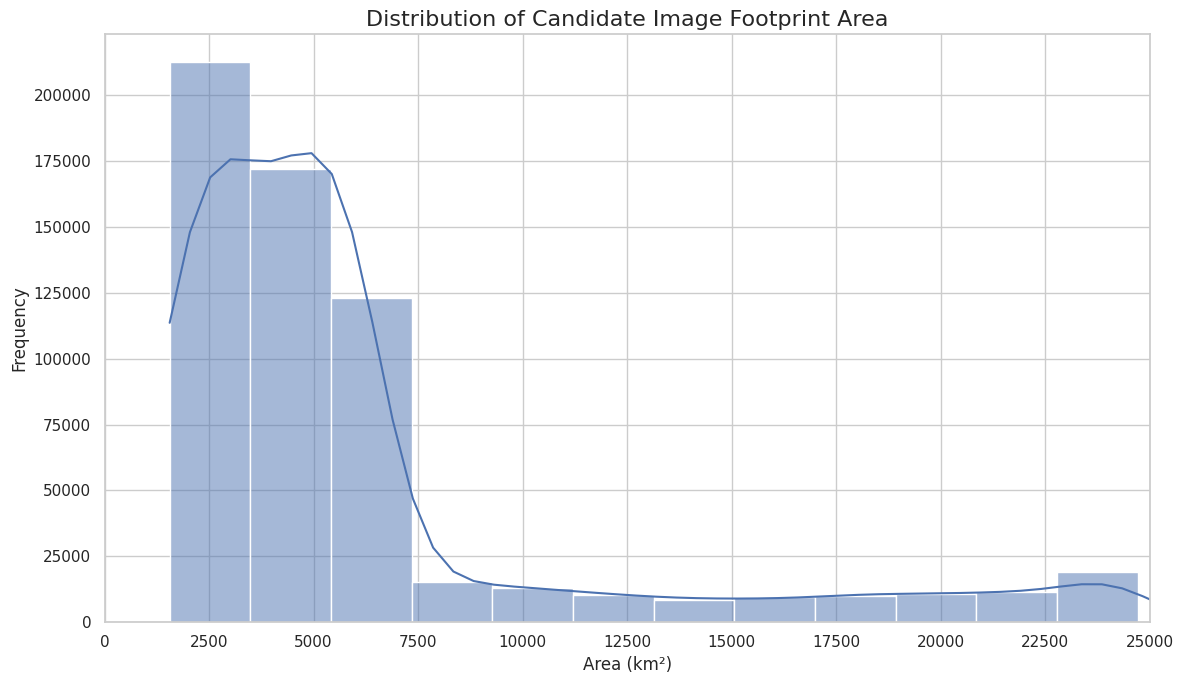


Descriptive Statistics for Image Area (km²):


count    645984.000000
mean       8893.037097
std       14395.124159
min        1558.000000
25%        2896.000000
50%        4804.000000
75%        6115.000000
max       98003.000000
Name: sq_km_area, dtype: float64

In [7]:
print("\nGenerating Plot 2: Distribution of Image Area (km²)")

plt.figure(figsize=(12, 7))
sns.histplot(data=df, x='sq_km_area', kde=True, bins=50)

plt.title('Distribution of Candidate Image Footprint Area', fontsize=16)
plt.xlabel('Area (km²)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.locator_params(axis='x', nbins=10)  # Increase the number of x-axis ticks
plt.xlim(0, 25000)

# Optional: If the data is heavily skewed, a log scale might be useful
# plt.xscale('log')
# plt.title('Distribution of Image Footprint Area (Log Scale)', fontsize=16)

plt.tight_layout()
plt.show()

# Also show descriptive statistics for the area
print("\nDescriptive Statistics for Image Area (km²):")
display(df['sq_km_area'].describe())

In [8]:
import os
import numpy as np
import pandas as pd
import folium
from tqdm import tqdm

# --- Configuration ---
TARGET_YEAR = 2020
SAMPLE_SIZE = 10000
HTML_FILENAME = "coverage_of_the_data_base_images.html"

# --- Dummy DataFrame for demonstration ---
# Replace this with your actual DataFrame loading
# df = pd.read_csv("your_data.csv")

# Example format:
# df = pd.DataFrame({
#     'year': [2020] * 3,
#     'lat1': [...], 'lon1': [...],
#     'lat2': [...], 'lon2': [...],
#     'lat3': [...], 'lon3': [...],
#     'lat4': [...], 'lon4': [...]
# })

# Filter the year
print(f"Preparing data for year {TARGET_YEAR}...")
df_year = df[df['year'] == TARGET_YEAR].copy()

if len(df_year) == 0:
    print(f"No data available for the year {TARGET_YEAR}.")
else:
    # Sample rows
    sample_df = df_year if len(df_year) < SAMPLE_SIZE else df_year.sample(n=SAMPLE_SIZE, random_state=42)

    # Collect footprint polygons
    footprints = []
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Creating footprints"):
        fp = [
            (row['lat1'], row['lon1']), (row['lat2'], row['lon2']),
            (row['lat3'], row['lon3']), (row['lat4'], row['lon4']),
            (row['lat1'], row['lon1'])  # close the polygon
        ]
        footprints.append(fp)

    # Center map around mean of all points
    all_lats = [lat for fp in footprints for lat, _ in fp]
    all_lons = [lon for fp in footprints for _, lon in fp]
    center_lat, center_lon = np.mean(all_lats), np.mean(all_lons)

    print("Generating Leaflet map...")
    m = folium.Map(location=[center_lat, center_lon], zoom_start=2, tiles="CartoDB dark_matter")

    # Add all polygons
    for fp in tqdm(footprints, desc="Drawing polygons"):
        folium.Polygon(
            locations=fp,
            color='blue',
            fill=True,
            fill_opacity=0.25,
            weight=1
        ).add_to(m)

    # Add legend (manual via HTML)
    legend_html = '''
     <div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: 60px;
                 background-color: white; border:2px solid grey; z-index:9999;
                 font-size:14px; padding: 10px;">
     <b>Legend</b><br>
     <span style="color:cyan;">■</span> Database Images ({})
     </div>
     '''.format(len(footprints))
    m.get_root().html.add_child(folium.Element(legend_html))

    # Save the map
    m.save(HTML_FILENAME)
    print(f"Map saved as '{HTML_FILENAME}'")


Preparing data for year 2020...


Creating footprints: 100%|██████████| 10000/10000 [00:00<00:00, 32046.28it/s]


Generating Leaflet map...


Drawing polygons: 100%|██████████| 10000/10000 [00:00<00:00, 69850.35it/s]


Map saved as 'coverage_of_the_data_base_images.html'



Generating Plot 4: Randomly Sampled Candidate Images


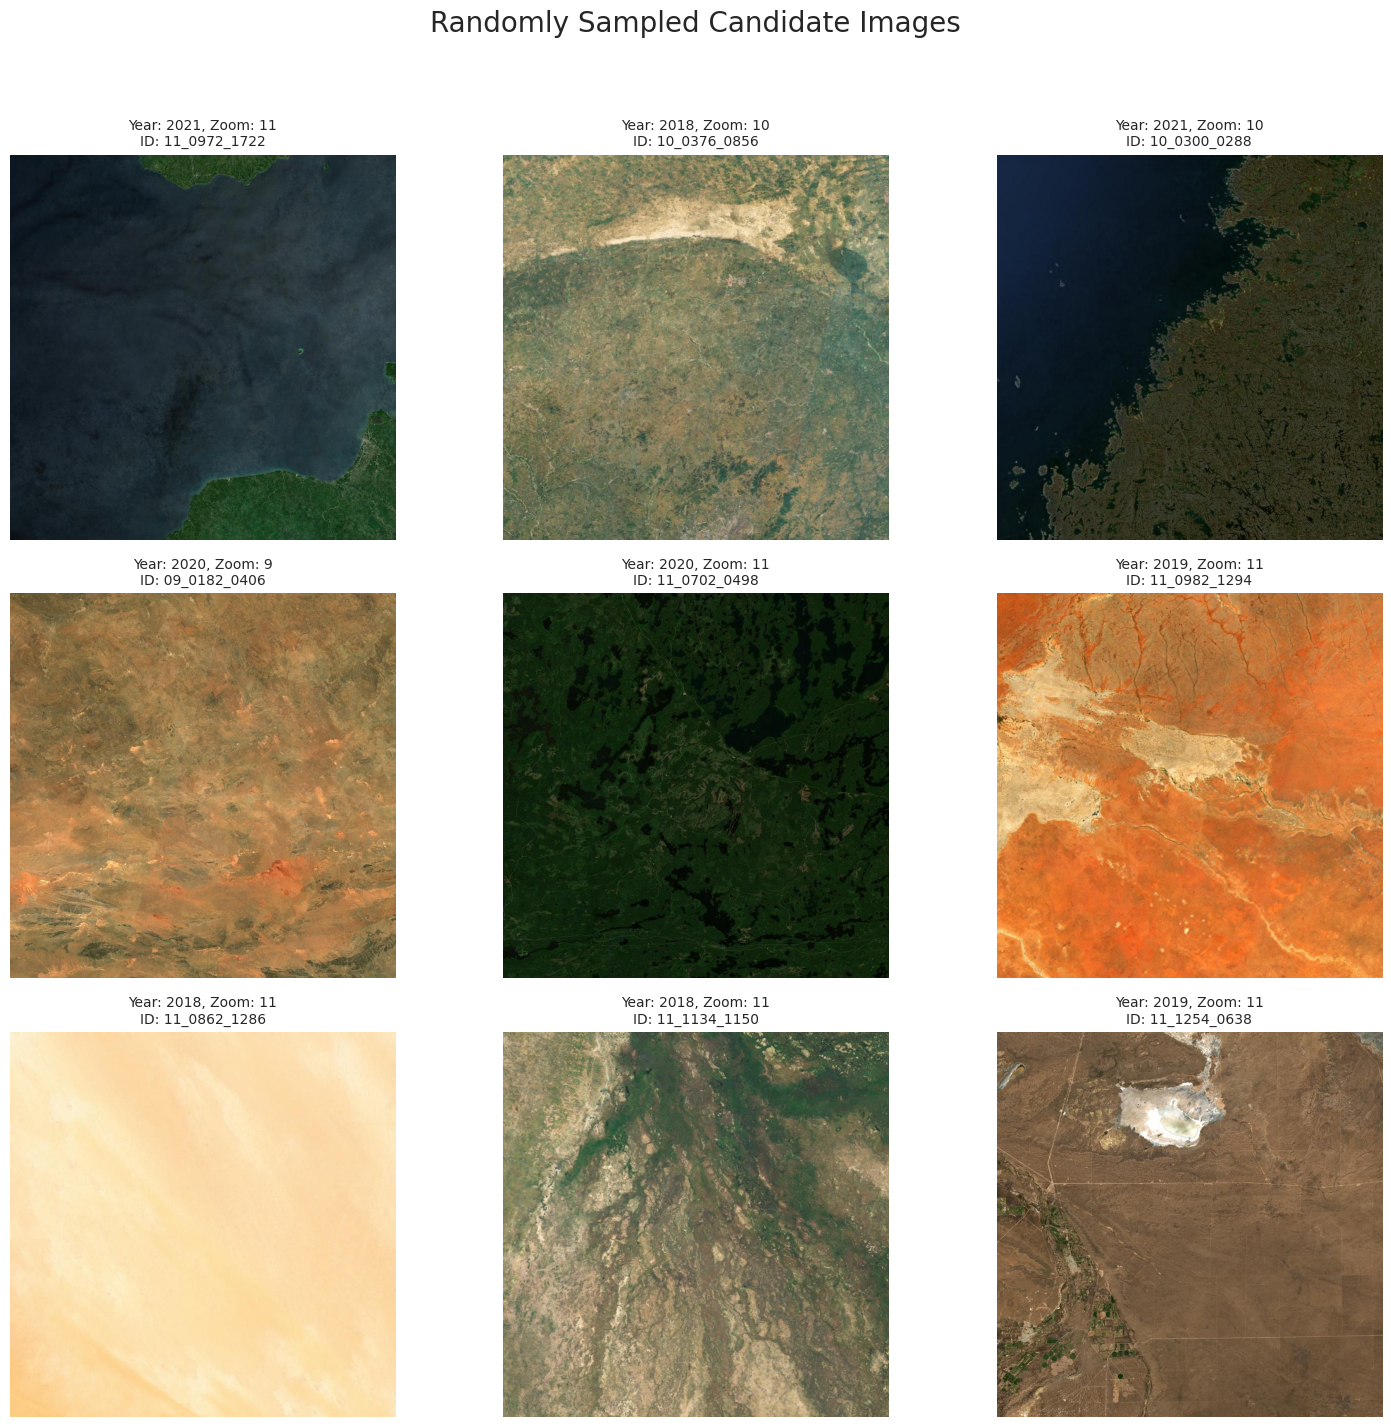

In [10]:
from PIL import Image

print("\nGenerating Plot 4: Randomly Sampled Candidate Images")

# --- Configuration ---
NUM_IMAGES = 9

# Check if we have enough images to sample from
if len(df) < NUM_IMAGES:
    print(f"Not enough images in the dataset to sample {NUM_IMAGES}. Need at least {NUM_IMAGES}.")
else:
    # Randomly sample 9 images from the entire dataset
    sample_images_df = df.sample(n=NUM_IMAGES, random_state=100)

    # Create a 3x3 subplot grid
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through the sampled images and plot them
    for i, (index, row) in enumerate(sample_images_df.iterrows()):
        ax = axes[i]
        try:
            # Open the image file
            img = Image.open(row['filepath'])
            ax.imshow(img)
            # Set a title with some metadata
            ax.set_title(f"Year: {row['year']}, Zoom: {row['zoom']}\nID: {row['image_id']}", fontsize=10)
        except FileNotFoundError:
            ax.set_title(f"File not found:\n{row['filepath']}", fontsize=8, color='red')
        
        # Hide the axes' ticks and labels for a cleaner look
        ax.axis('off')

    plt.suptitle('Randomly Sampled Candidate Images', fontsize=20)
    # Use tight_layout to prevent titles from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


<h2> Queries </h2>


Generating Plot 5: Randomly Sampled Query Images


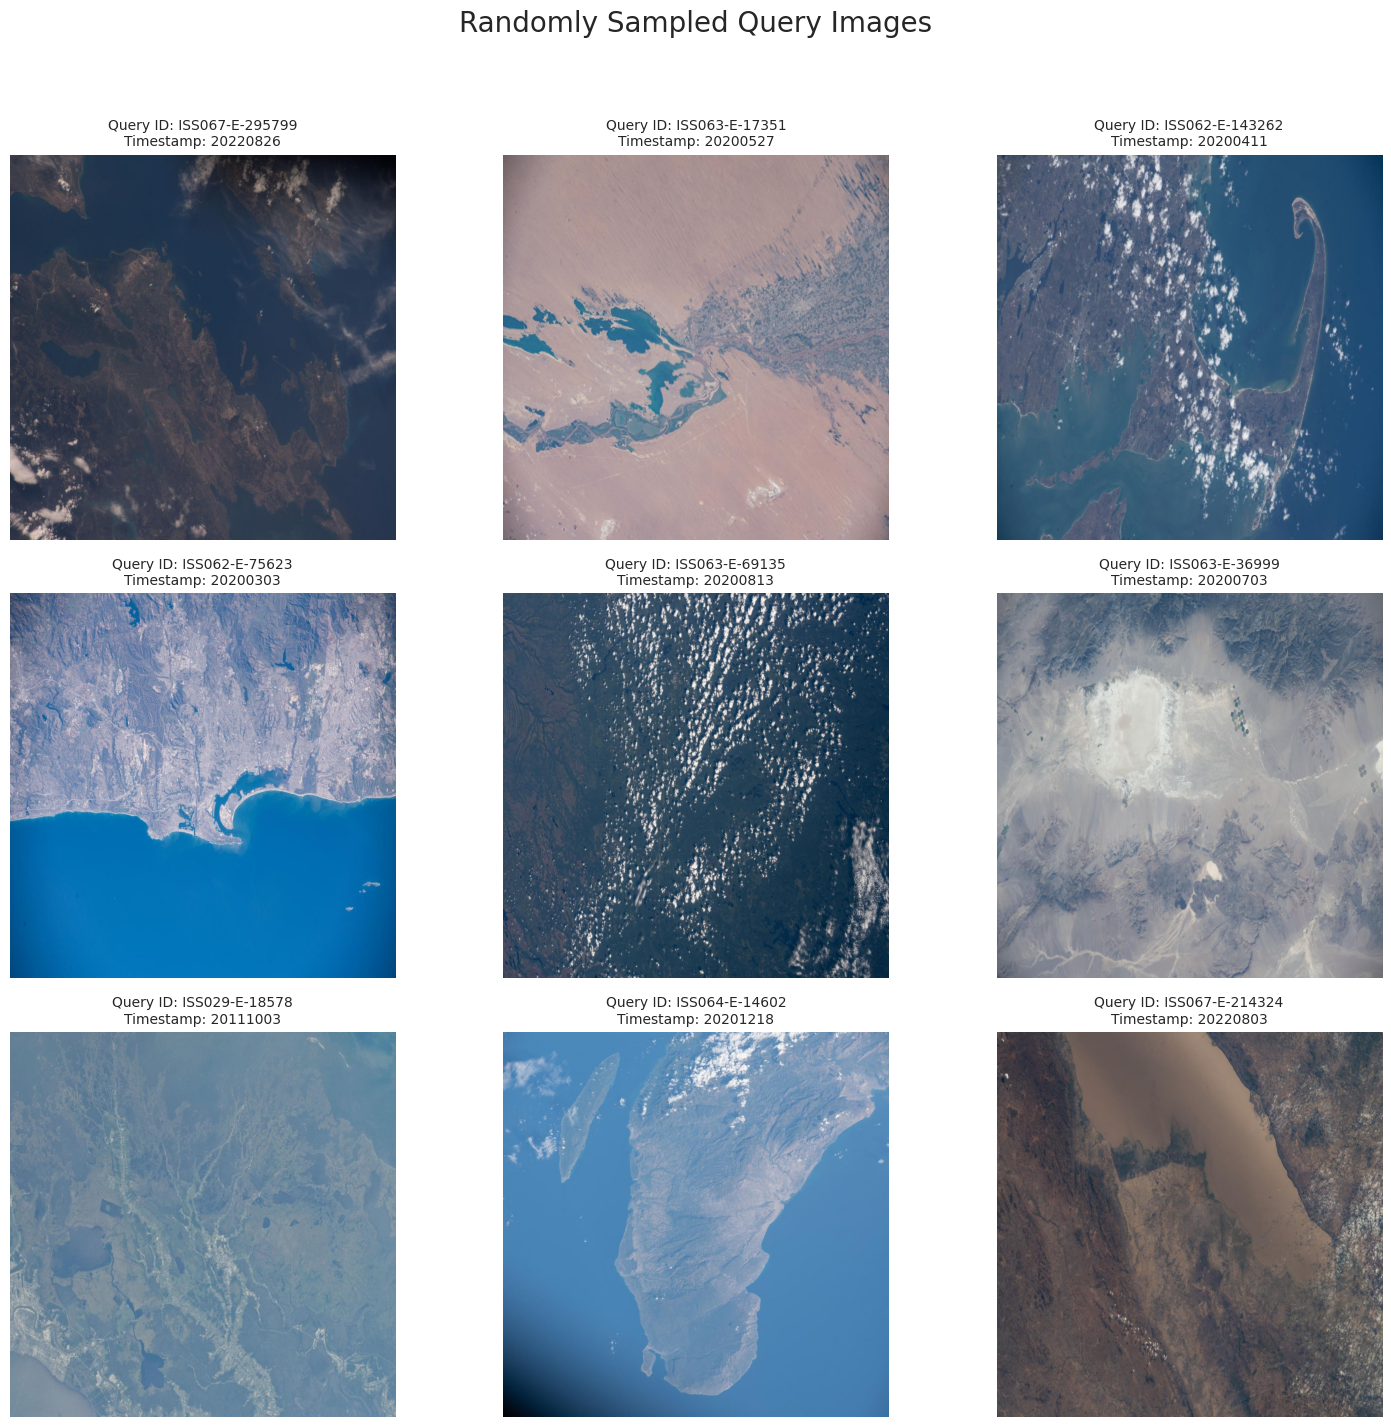

In [11]:
from pathlib import Path
import random
from PIL import Image
import matplotlib.pyplot as plt

print("\nGenerating Plot 5: Randomly Sampled Query Images")

# --- Configuration ---
QUERY_DIR = Path("../data/queries")
NUM_IMAGES = 9

# --- Find and Sample Query Images ---
if not QUERY_DIR.exists():
    print(f"Error: The query directory '{QUERY_DIR}' does not exist.")
else:
    # Recursively find all .jpg files in the directory
    query_image_paths = list(QUERY_DIR.rglob("*.jpg"))

    if not query_image_paths:
        print(f"No .jpg images found in '{QUERY_DIR}'.")
    elif len(query_image_paths) < NUM_IMAGES:
        print(f"Warning: Only {len(query_image_paths)} query images found. Displaying all of them.")
        sample_paths = query_image_paths
    else:
        # Randomly sample 9 unique image paths
        sample_paths = random.sample(query_image_paths, NUM_IMAGES)

    # --- Create the Plot ---
    if query_image_paths:
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()

        for i, filepath in enumerate(sample_paths):
            ax = axes[i]
            try:
                # Open the image
                img = Image.open(filepath)
                ax.imshow(img)

                # Parse filename for metadata to use in the title
                # Format: @lat1@...@image_id@timestamp@...
                filename_parts = filepath.stem.split("@")[1:]
                image_id = filename_parts[8]
                timestamp = filename_parts[9]
                ax.set_title(f"Query ID: {image_id}\nTimestamp: {timestamp}", fontsize=10)

            except (FileNotFoundError, IndexError) as e:
                ax.set_title(f"Error loading/parsing:\n{filepath.name}", fontsize=8, color='red')
            
            # Hide axis ticks and labels
            ax.axis('off')
        
        # Hide any unused subplots if there were fewer than 9 images
        for j in range(len(sample_paths), len(axes)):
            axes[j].axis('off')

        plt.suptitle('Randomly Sampled Query Images', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


Generating Plot 6: Distribution of Query Image Area (km²)
Parsing area metadata from 17763 query images...


  0%|          | 0/17763 [00:00<?, ?it/s]

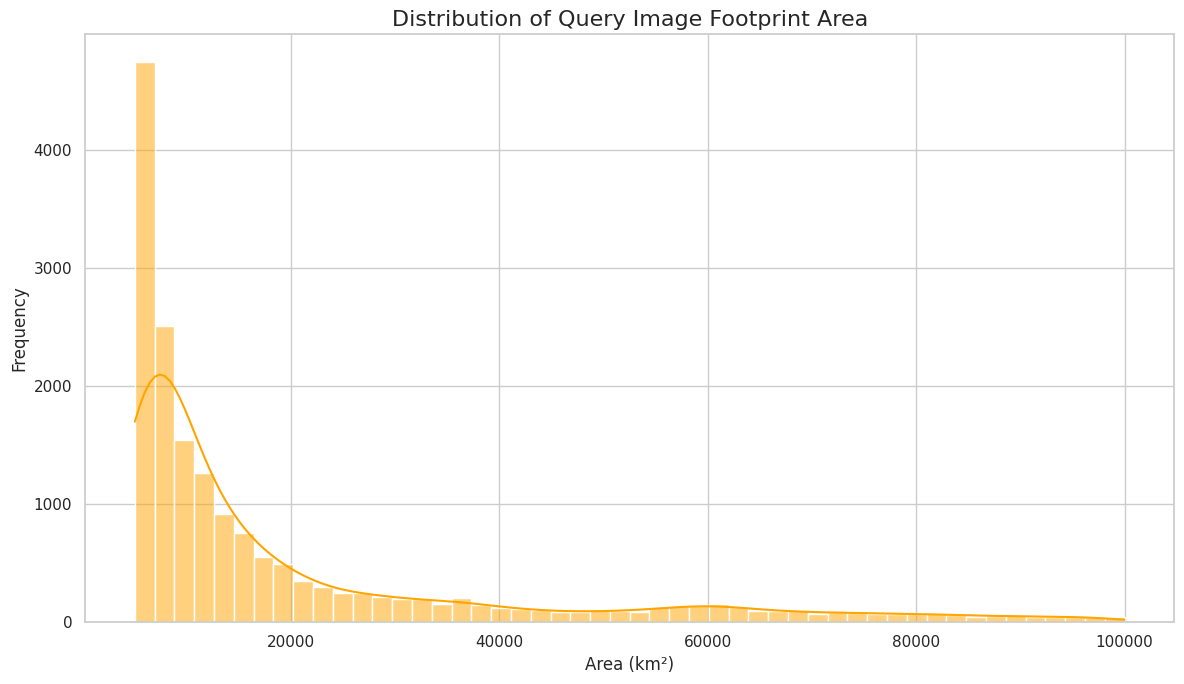


Descriptive Statistics for Query Image Area (km²):


count    17763.000000
mean     20331.140855
std      21283.849883
min       5001.000000
25%       6752.500000
50%      10830.000000
75%      23342.000000
max      99994.000000
Name: sq_km_area, dtype: float64

In [12]:
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

print("\nGenerating Plot 6: Distribution of Query Image Area (km²)")

# --- Configuration ---
QUERY_DIR = Path("../data/queries")

# --- Parse Query Image Metadata ---
if not QUERY_DIR.exists():
    print(f"Error: The query directory '{QUERY_DIR}' does not exist.")
else:
    query_records = []
    # Recursively find all .jpg files
    query_image_paths = list(QUERY_DIR.rglob("*.jpg"))

    if not query_image_paths:
        print(f"No .jpg images found in '{QUERY_DIR}'.")
    else:
        print(f"Parsing area metadata from {len(query_image_paths)} query images...")
        for filepath in tqdm(query_image_paths):
            try:
                # Filename format: @...@sq_km_area@...@.jpg
                # The area is the 13th element (index 12)
                filename_parts = filepath.stem.split("@")[1:]
                area = float(filename_parts[12])
                query_records.append({'sq_km_area': area})
            except (IndexError, ValueError):
                print(f"Could not parse area from file: {filepath.name}")

        # Create a DataFrame from the parsed data
        df_queries = pd.DataFrame(query_records)

        # --- Generate the Plot ---
        plt.figure(figsize=(12, 7))
        # Added color='orange' to the histplot function
        sns.histplot(
            data=df_queries,
            x='sq_km_area',
            kde=True,
            bins=50,
            color='orange'
        )

        plt.title('Distribution of Query Image Footprint Area', fontsize=16)
        plt.xlabel('Area (km²)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.show()

        # --- Display Descriptive Statistics ---
        print("\nDescriptive Statistics for Query Image Area (km²):")
        display(df_queries['sq_km_area'].describe())